In [1]:
library(lindia)
library(tidyverse)
library(caret)
library(leaps)
library(MASS)
library(lme4) #random effect

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.3
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack




In [9]:
#install.packages("emmeans")
library(DHARMa)
library(lindia)
library(tidyverse)
library(caret)
library(leaps)
library(MASS)
library(modEvA)
library(dplyr)
library(lme4) #random effect
library(broom)
library(ggpubr) 
library(rstatix)
library(WRS2) #robust ancova
library(lmerTest) #like lmer but with p-value
library(emmeans)

#levenetest
library(car)

This is DHARMa 0.3.3.0. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa') Note: Syntax of plotResiduals has changed in 0.3.0, see ?plotResiduals for details

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4


Attaching package: 'rstatix'


The following object is masked from 'package:MASS':

    select


The following object is masked from 'package:stats':

    filter



Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step


Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some




# Download data

In [3]:
path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/correctlightschedule_'
df = read.csv(file.path(path_,'Adaptability_Stat.csv'), header = TRUE, sep = ";")
#li_var_cont = c('ID0','ID1','ID2','ID3','ID4','ID5','ID6','ID7')
#df$maxsevGap0_divided_maxsev_round = round(df$maxsevGap0_divided_maxsev, 1)
#df$maxsevGap0_divided_maxsev_round_log <- log(df$maxsevGap0_divided_maxsev_round)
#print(as.data.frame(table(df$maxsevGap0_divided_maxsev_round)))
#df_ = df[,c(li_var_cont, 'maxsevGap0_divided_maxsev_round','maxsevGap0_divided_maxsev_round_log')] 
print(dim(df))
summary(df)

[1] 98 67


    HenID           chi2distance       chi2distance_ALL_15  DTW_30_all       
 Length:98          Length:98          Length:98           Length:98         
 Class :character   Class :character   Class :character    Class :character  
 Mode  :character   Mode  :character   Mode  :character    Mode  :character  
                                                                             
                                                                             
                                                                             
 DTW_30_1_Zone      DTW_30_2_Zone      DTW_30_3_Zone      DTW_30_4_Zone     
 Length:98          Length:98          Length:98          Length:98         
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                     

# Linear mixed effect model

#random seed for reproductibility
set.seed(0)

#set up repeated k-fold cross-validation
train.control = trainControl(method = "cv", number=3)

#fit linear regression with stepwise selection (method: "leapBackward","leapForward", "leapSeq")
step.model = train(Feathers ~ ., #mean_percentage_time_outside_while_WG_open+ mean_latency_1_Zone+perc_days_nomvtamngfirst3days+mean_DTW_30_5_Zone+mssd_DTW_30_5_Zone+mssd_vertical_travel_distance+mean_vertical_travel_distance,
                   data=df,
                   method = "leapSeq", 
                    tuneGrid = data.frame(nvmax=1:6),
                    trControl = train.control, na.action = na.exclude) #na.exclude na.omit
step.model$results
nv = step.model$bestTune
print(nv)
summary(step.model$finalModel)

In [4]:
#lindia::gg_diagnose(model)

model_final = lm(Feathers ~ mean_percentage_time_outside_while_WG_open+nbr_obs_percentage_time_outside_while_WG_open,
                 data=df)
summary(model_final) 
plot(model_final)
Dsquared(model_final)
bin.resid.df =  simulateResiduals(model_final, 2000)
plotSimulatedResiduals(bin.resid.df)
plot(bin.resid.df)

boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Feathers ~ mean_percentage_time_outside_while_WG_open + nbr_obs_percentage_time_outside_while_WG_open +  
    (1 | Treatment/PenID)
   Data: df

REML criterion at convergence: 618.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.51552 -0.57517  0.04309  0.59825  1.92264 

Random effects:
 Groups          Name        Variance Std.Dev.
 PenID:Treatment (Intercept)  4.773   2.185   
 Treatment       (Intercept)  0.000   0.000   
 Residual                    30.025   5.480   
Number of obs: 98, groups:  PenID:Treatment, 8; Treatment, 2

Fixed effects:
                                              Estimate Std. Error       df
(Intercept)                                   68.32001   14.41072  6.27635
mean_percentage_time_outside_while_WG_open     0.20157    0.07929 92.20753
nbr_obs_percentage_time_outside_while_WG_open  0.41417    0.34163  6.35940
                            

boundary (singular) fit: see ?isSingular



,npar,logLik,AIC,LRT,Df,Pr(>Chisq)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,6,-309.4722,630.9444,NA,NA,NA
(1 | PenID:Treatment),5,-311.4781,632.9562,4.011792e+00,1,0.0451831
(1 | Treatment),5,-309.4722,628.9444,-1.370495e-09,1,1.0000000


Computing profile confidence intervals ...



,2.5 %,97.5 %
.sig01,0.00000000,3.9104232
.sig02,0.00000000,2.9837321
.sigma,4.74156623,6.3625136
(Intercept),40.82110928,95.9319603
mean_percentage_time_outside_while_WG_open,0.04646585,0.3578597
nbr_obs_percentage_time_outside_while_WG_open,-0.24022916,1.0655824


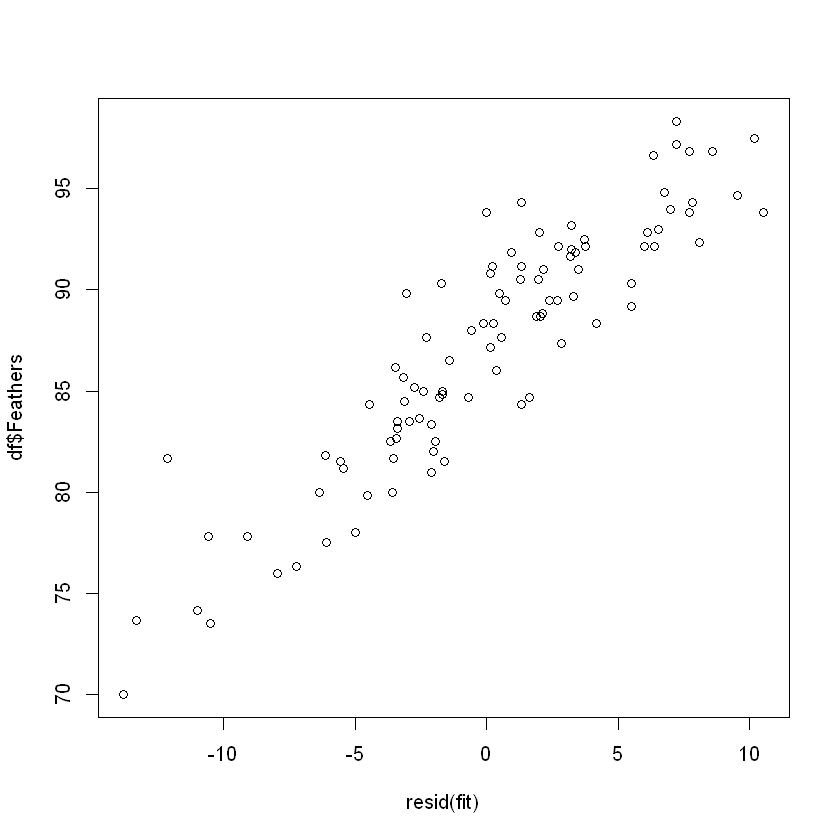

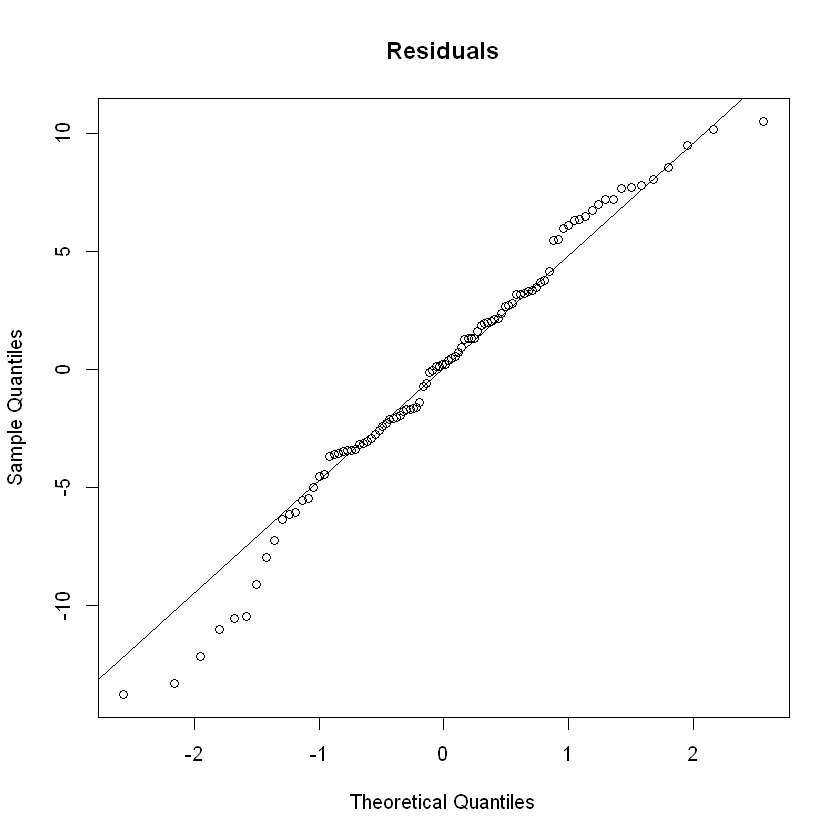

Warning message in ranef.merMod(fit, postVar = TRUE):
"'postVar' is deprecated: please use 'condVar' instead"


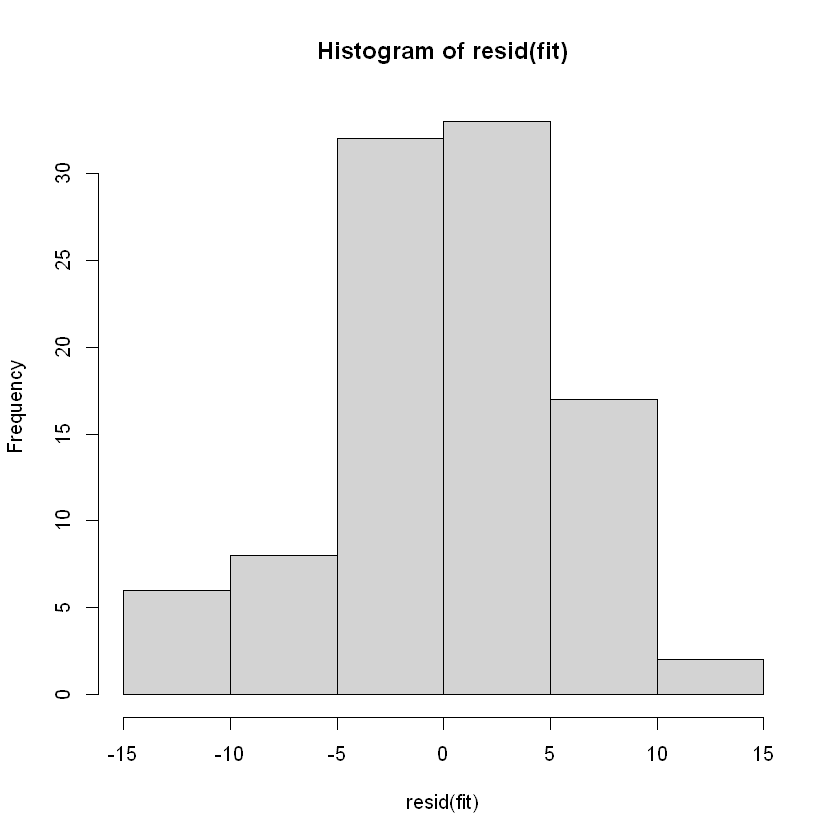

$`PenID:Treatment`

$Treatment


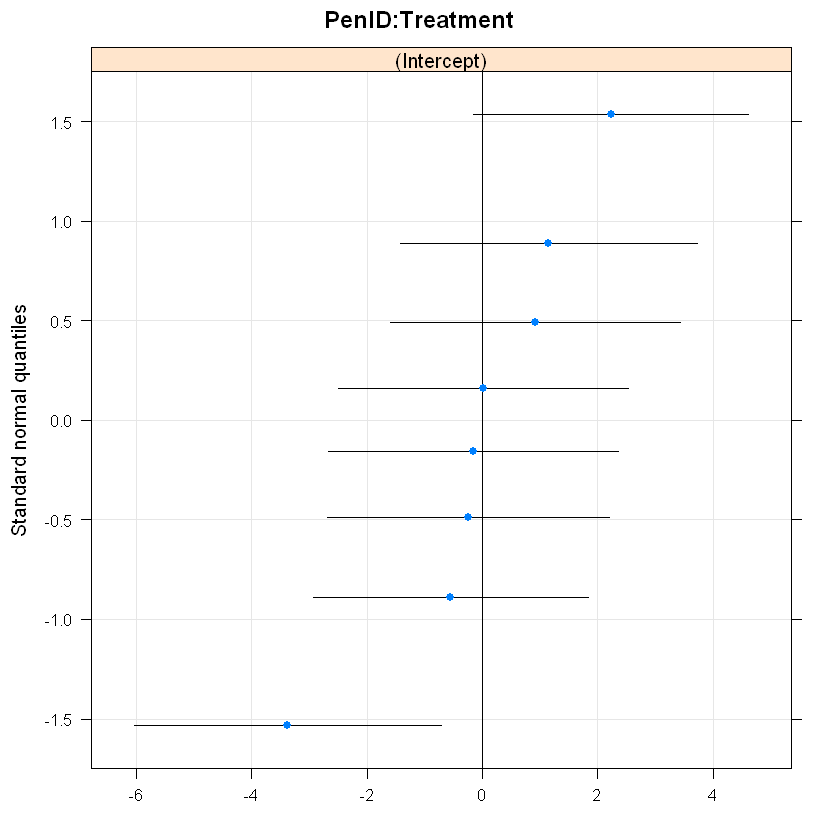

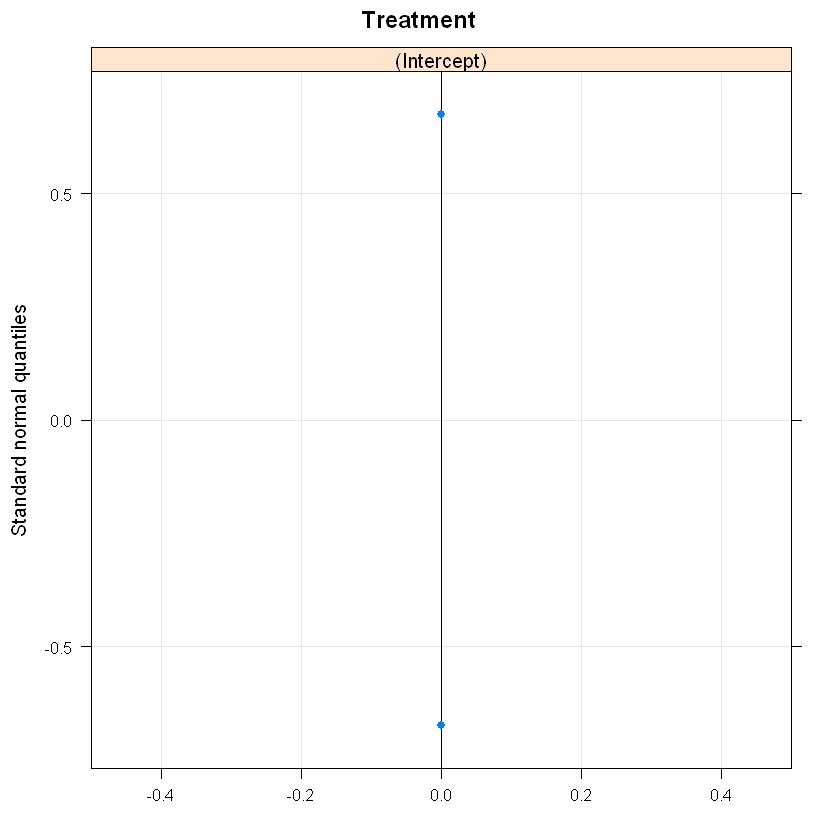

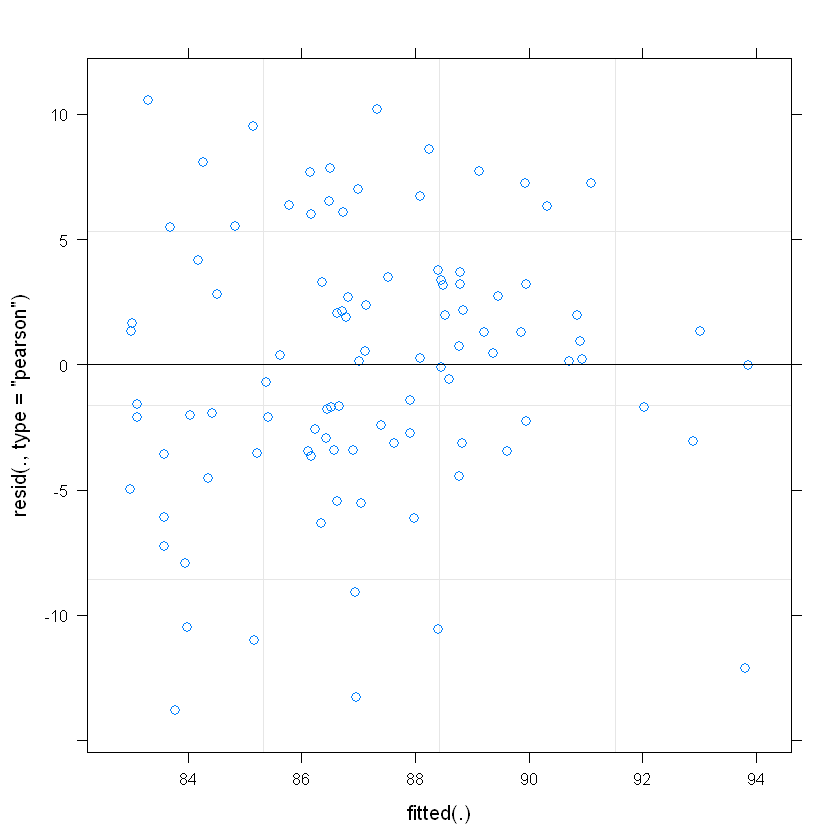

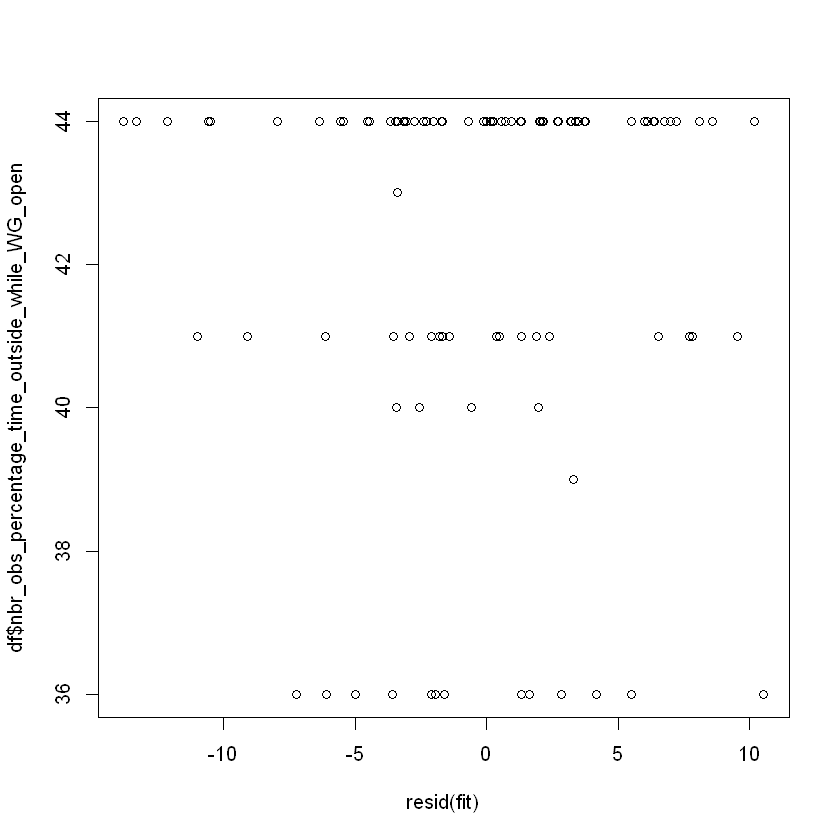

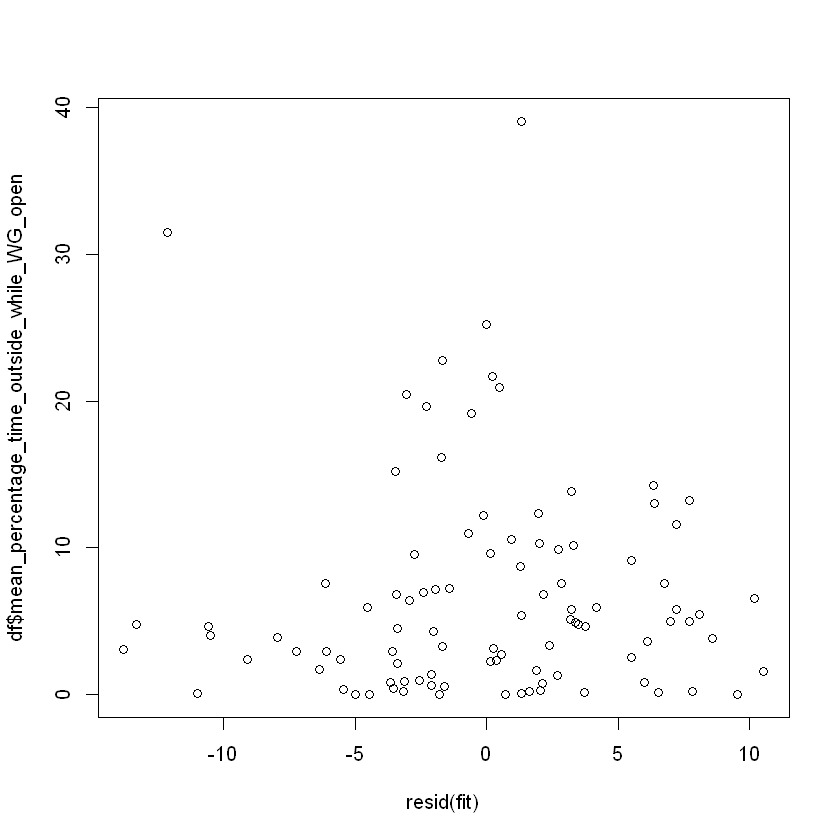

In [13]:
#modeling with randm effect, if we wan tto see across different HA for example
#modelling
fit = lmerTest::lmer(Feathers ~ mean_percentage_time_outside_while_WG_open + nbr_obs_percentage_time_outside_while_WG_open + (1|Treatment/PenID), 
           data=df)
#PenID
#capture.output(summary(fit), file=file.path(path_,paste(name,'.txt', sep='')), append=TRUE)
summary(fit)
#tests the hypothesis that the random effect variation is significant versus the null that there is no between group-level 
#variation
rand(fit)
confint(fit)

#Assumptions
######linearity of predictors: plot residual vs observed
plot(resid(fit),df$Feathers)

###### normally distributed residuals
#qqmath(fit, id=0.05)
qqnorm(resid(fit), main = "Residuals")
qqline(resid(fit))
hist(resid(fit))
###### normally of random effects
qqmath(ranef(fit,postVar = TRUE))

######check homogeneity of variance (residuals has constant variance)
#variance of the residuals is equal across groups. Even spread around the centered line?
plot(fit)

###### check if the residuals are independent. This can be checked by plotting residuals against covariates - especially time-varying or spatial covariates. There should not be any systematic pattern
plot(resid(fit),df$nbr_obs_percentage_time_outside_while_WG_open)
plot(resid(fit),df$mean_percentage_time_outside_while_WG_open)
#warnign due to random efffect beeing very small

`geom_smooth()` using formula 'y ~ x'



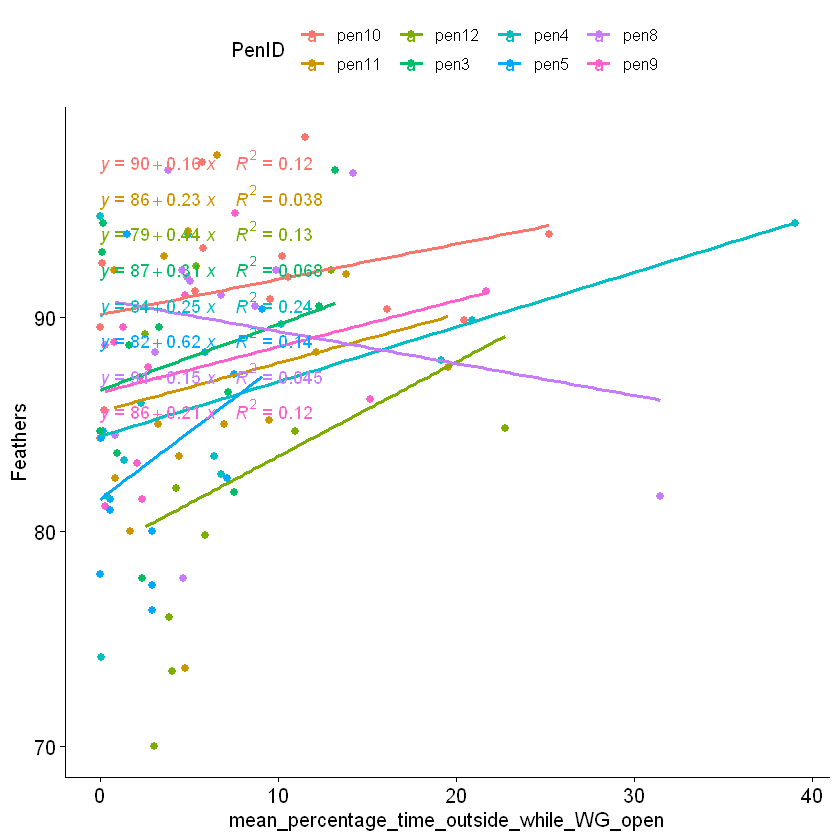

In [10]:
ggscatter(
  df, x = "mean_percentage_time_outside_while_WG_open", y = "Feathers",
  color = "PenID", add = "reg.line"
  )+
  stat_regline_equation(
    aes(label =  paste(..eq.label.., ..rr.label.., sep = "~~~~"), color = PenID)
    )

`geom_smooth()` using formula 'y ~ x'



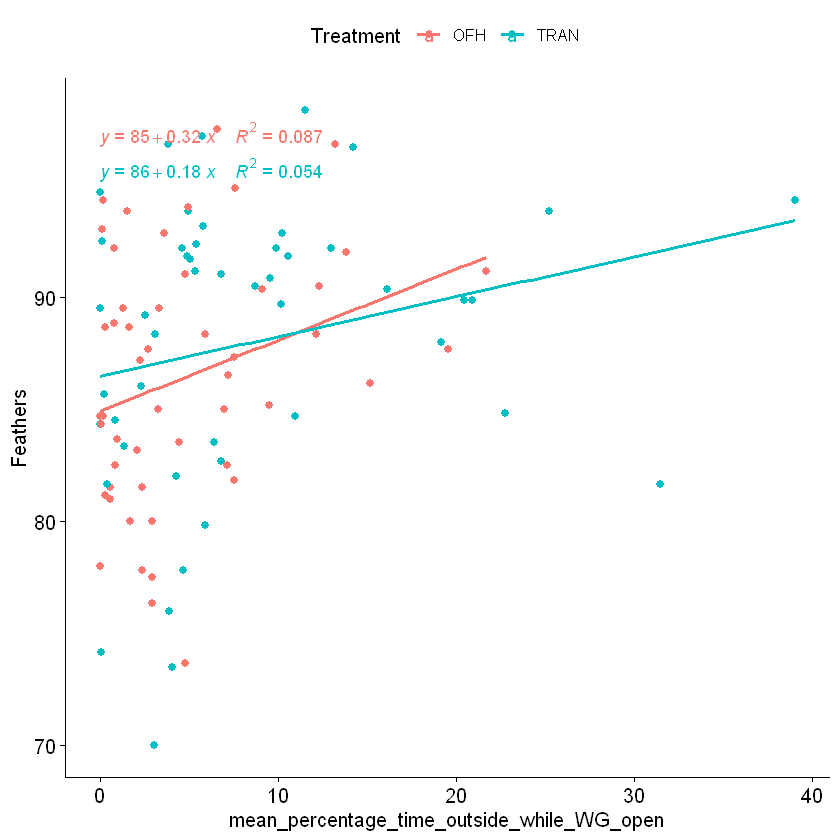

In [12]:
ggscatter(
  df, x = "mean_percentage_time_outside_while_WG_open", y = "Feathers",
  color = "Treatment", add = "reg.line"
  )+
  stat_regline_equation(
    aes(label =  paste(..eq.label.., ..rr.label.., sep = "~~~~"), color = Treatment)
    )

boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: severity ~ mean_vertical_travel_distance + (1 | Treatment/PenID)
   Data: df

REML criterion at convergence: 797.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.81731 -0.77393  0.08999  0.48903  3.00156 

Random effects:
 Groups          Name        Variance  Std.Dev. 
 PenID:Treatment (Intercept) 1.958e+01 4.425e+00
 Treatment       (Intercept) 8.344e-08 2.889e-04
 Residual                    1.924e+02 1.387e+01
Number of obs: 98, groups:  PenID:Treatment, 8; Treatment, 2

Fixed effects:
                              Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)                    33.8461     4.9333 60.3671   6.861 4.21e-09 ***
mean_vertical_travel_distance  -0.1274     0.1051 94.1076  -1.212    0.228    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
mn_vrtcl_t_ -0.905
optimizer (nlop

,npar,logLik,AIC,LRT,Df,Pr(>Chisq)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,5,-398.6822,807.3644,NA,NA,NA
(1 | PenID:Treatment),4,-400.0697,808.1393,2.774914e+00,1,0.09575181
(1 | Treatment),4,-398.6822,805.3644,-6.678874e-09,1,1.00000000


Computing profile confidence intervals ...



,2.5 %,97.5 %
.sig01,0.0000000,9.06689315
.sig02,0.0000000,7.77763127
.sigma,12.0079516,16.08656288
(Intercept),24.2576032,43.42123329
mean_vertical_travel_distance,-0.3322045,0.07864191


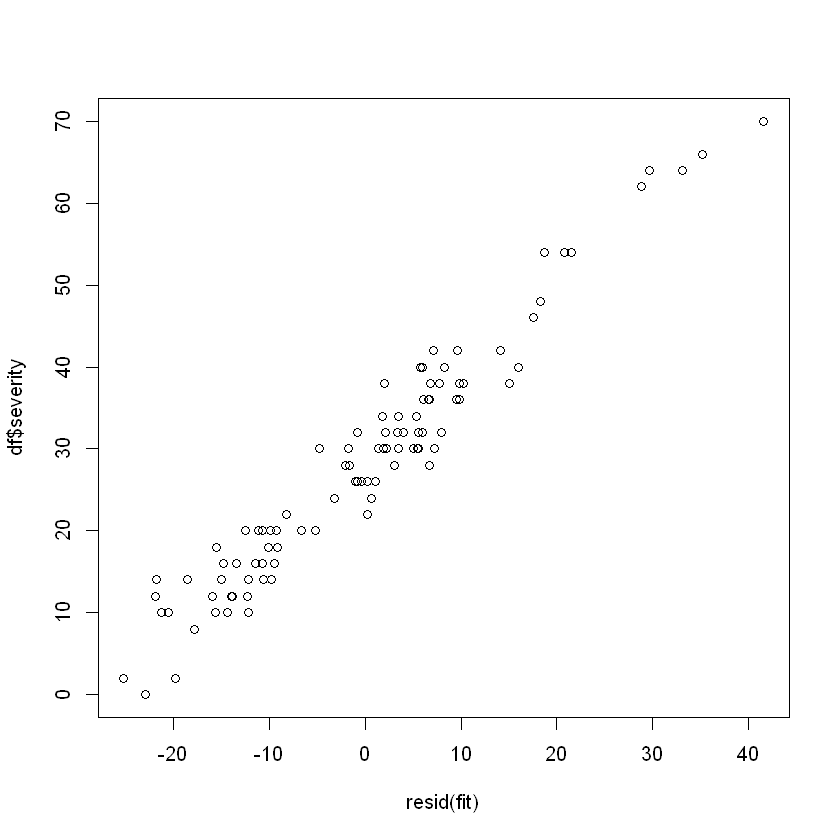

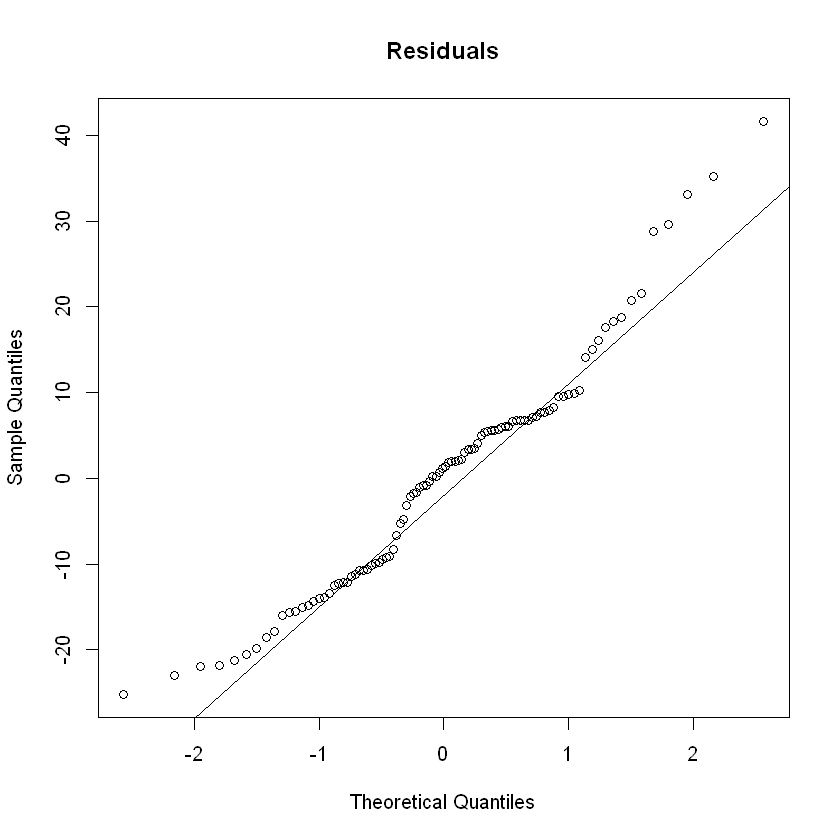

Warning message in ranef.merMod(fit, postVar = TRUE):
"'postVar' is deprecated: please use 'condVar' instead"


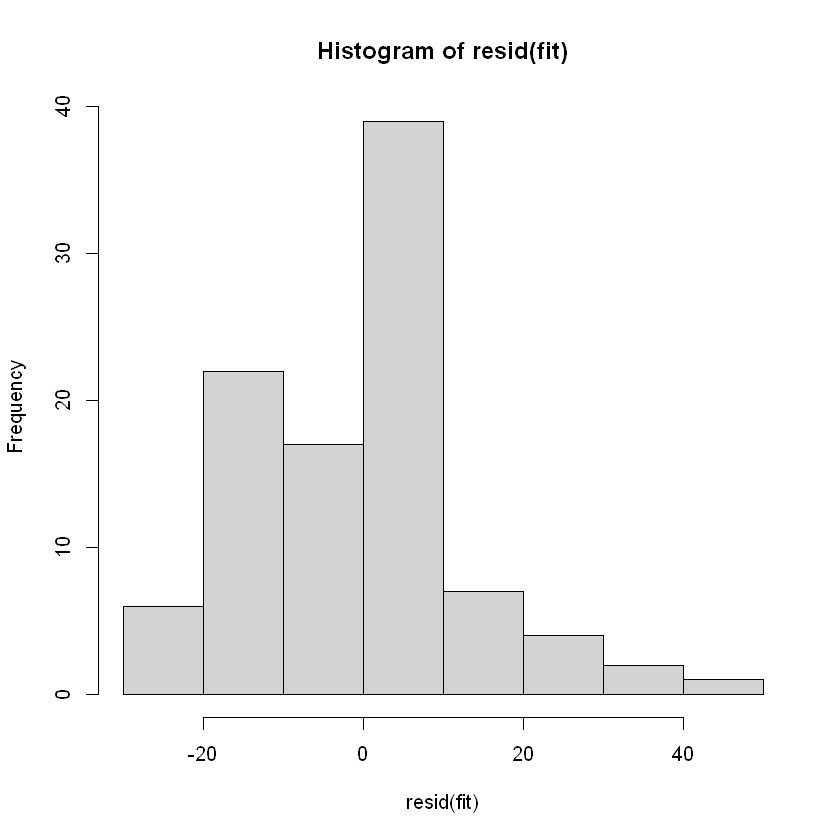

$`PenID:Treatment`

$Treatment


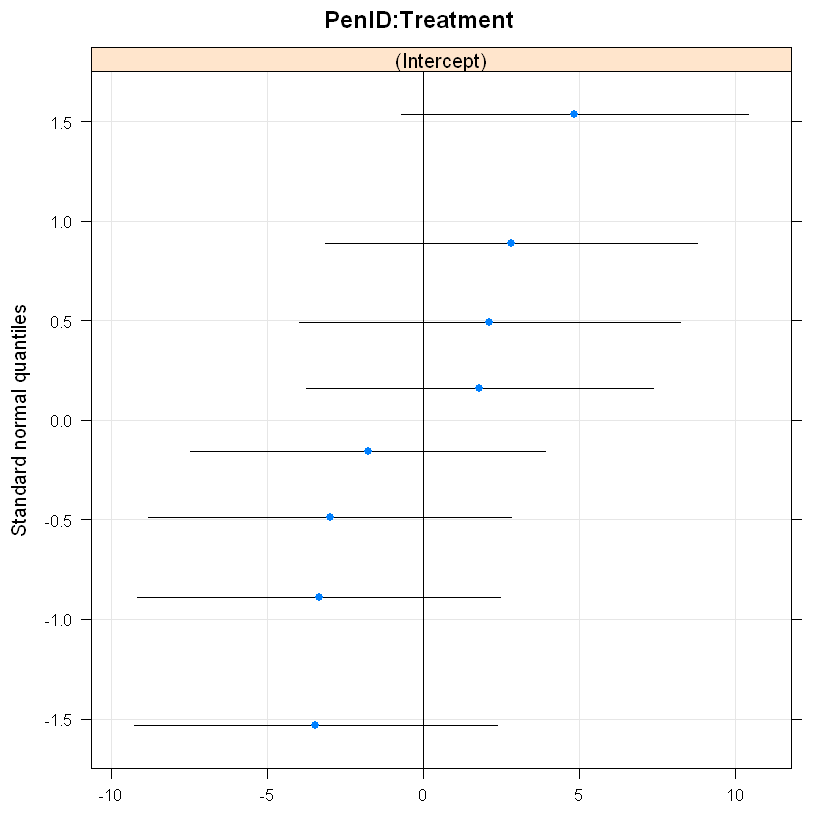

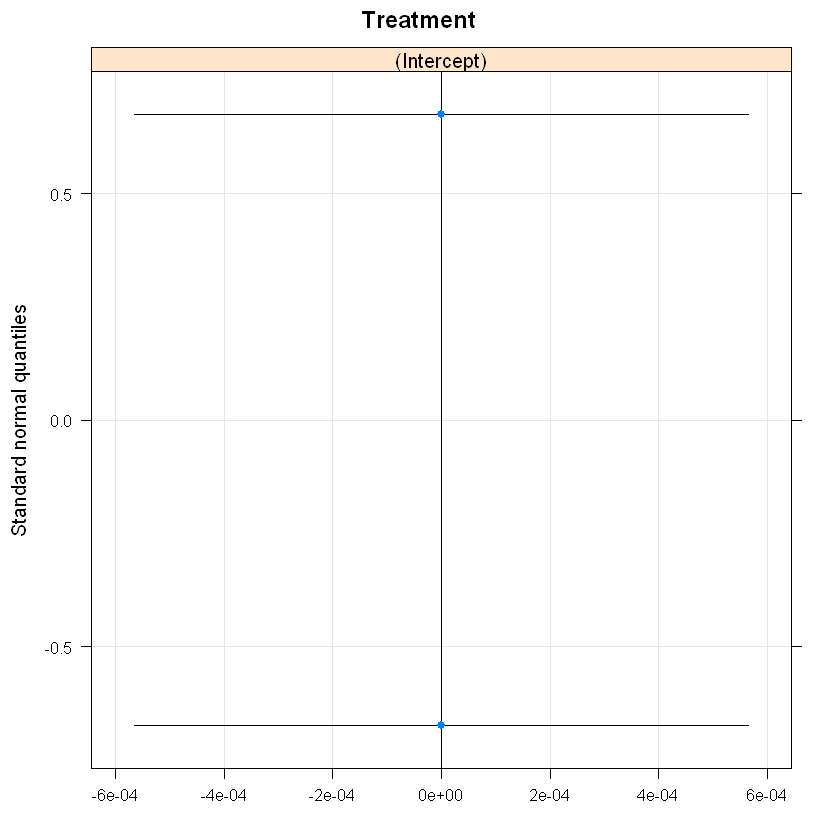

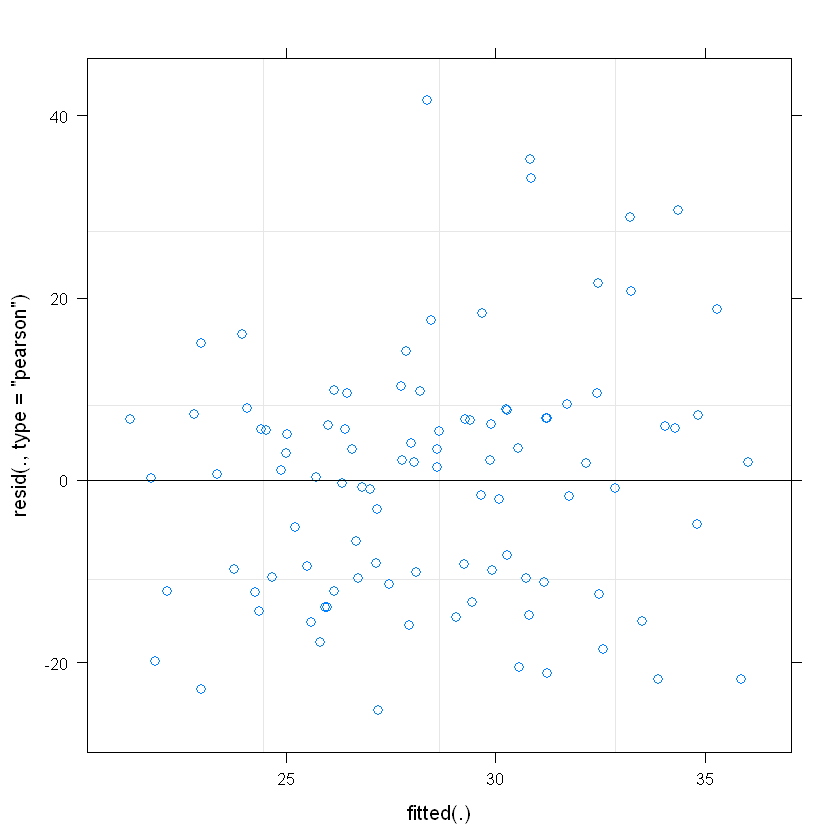

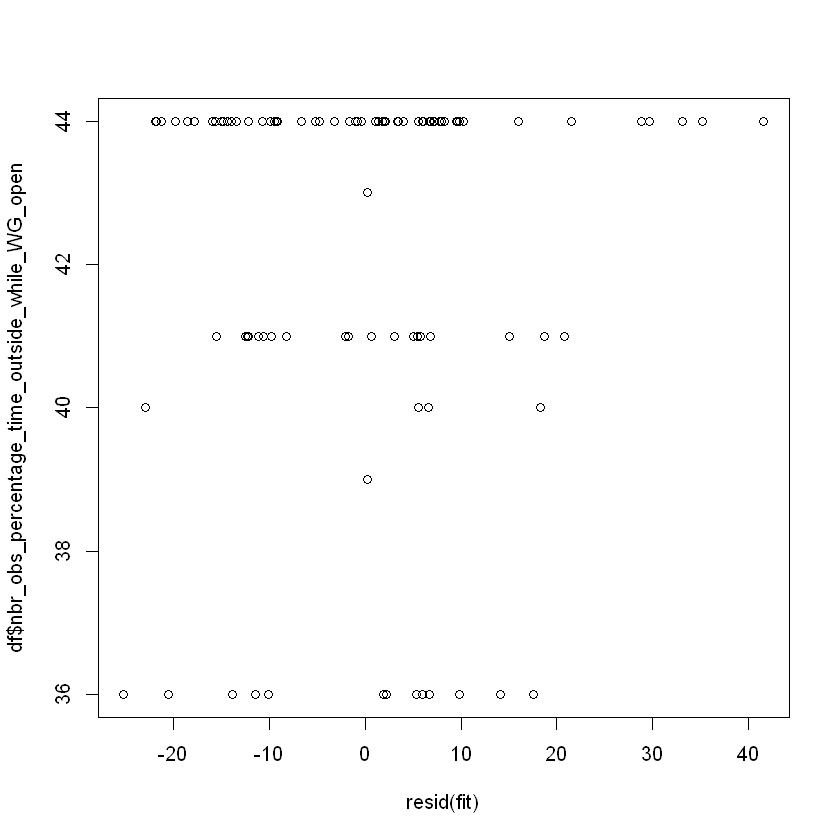

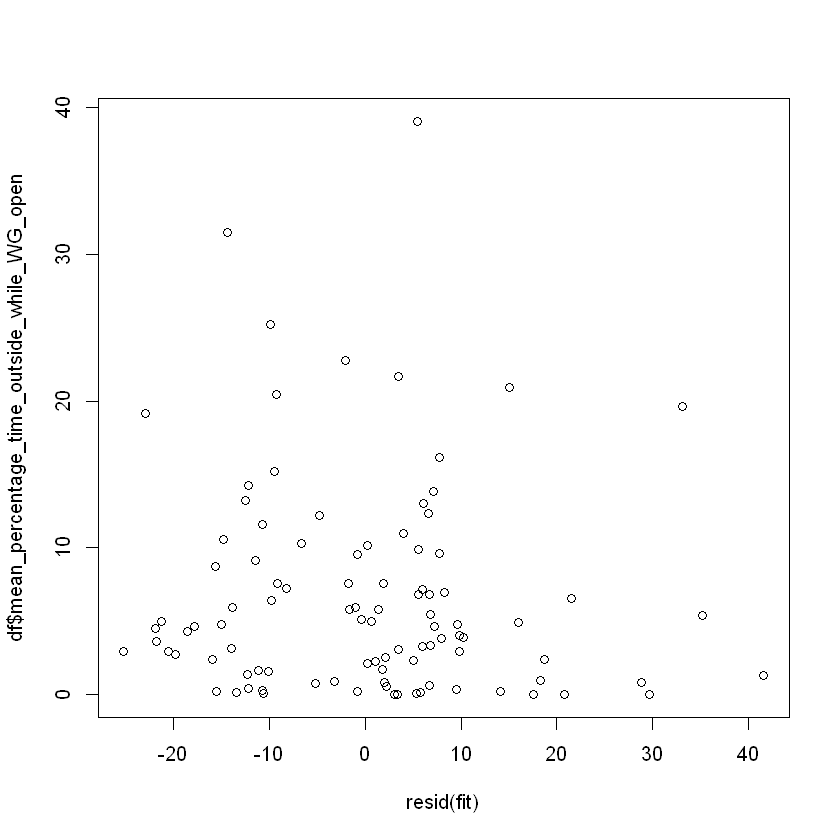

In [23]:
#modeling with randm effect, if we want to see across different HA for example
#modelling
fit = lmerTest::lmer(severity ~  mean_vertical_travel_distance + (1|Treatment/PenID), 
           data=df)
#PenID
#capture.output(summary(fit), file=file.path(path_,paste(name,'.txt', sep='')), append=TRUE)
summary(fit)
#tests the hypothesis that the random effect variation is significant versus the null that there is no between group-level 
#variation
rand(fit)
confint(fit)

#Assumptions
######linearity of predictors: plot residual vs observed
plot(resid(fit),df$severity)

###### normally distributed residuals
#qqmath(fit, id=0.05)
qqnorm(resid(fit), main = "Residuals")
qqline(resid(fit))
hist(resid(fit))
###### normally of random effects
qqmath(ranef(fit,postVar = TRUE))

######check homogeneity of variance (residuals has constant variance)
#variance of the residuals is equal across groups. Even spread around the centered line?
plot(fit)

###### check if the residuals are independent. This can be checked by plotting residuals against covariates - especially time-varying or spatial covariates. There should not be any systematic pattern
plot(resid(fit),df$nbr_obs_percentage_time_outside_while_WG_open)
plot(resid(fit),df$mean_percentage_time_outside_while_WG_open)